<a href="https://colab.research.google.com/github/UNCG-CSE/COVID-Team-2/blob/master/src/raiana/Raiana_Stage_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stage-3

- ▪ Utilize Linear or Non-Linear (polynomial) regression models to compare trends for NY state and its counties.(chose the one that fits best to your data)
Start your data from the first day of infections. X-Axis, number of days since the first case, Y-Axis number of new cases and deaths. Calcluate error using RMSE.
- ▪ Identify which counties are most at risk. Model for top 5 counties with cases within NY state and observe their trends.
- ▪ Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.
- ▪ Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases. 
- ▪ Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error).
o For example, percentage of population in certain age-group, socio-economic status, public transportation, work from home, etc.
o Show the relative importance of variables and explain why. 
Here you are using the variables for prediction of cases
(multi-variable) regression. Stage II was just correlation.
 
 
- ▪ For each of the aforemention analysis plot graphs,
  - o trend line
  - o confidence intervals (error in prediction)
  - o prediction path 

#Reading Datasets and importing Libarary 

In [135]:
#Using to mount google drive as i am using google colab for this assignment
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [136]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns


from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

from functools import reduce
import datetime

In [137]:
#reading dataset
covid_df= pd.read_csv("/content/drive/My Drive/Datascience/COVID-Team-2/data/superCOVID-19datafame.csv")
hopita_df = pd.read_csv("/content/drive/My Drive/Datascience/COVID-Team-2/data/Definitive_Health_USA_Hospital_Beds.csv")

#Cleaning and reorganizing data

In [138]:
#seleceting NY state only
covid_df =covid_df[covid_df['State']=='NY']
covid_df.drop(["State",'stateFIPS'],axis=1,inplace=True)
covid_NY_county_df = covid_df.set_index('countyFIPS')

#seleceting NY state for hospital dataset
hopita_df.dropna(axis=1,inplace=True,how='all')
hopita_NY_df=hopita_df[hopita_df['HQ_STATE']=="NY"]
hopita_NY_df = hopita_NY_df.groupby('FIPS').agg(sum) #suming up by FIPS
hopita_NY_df.index=hopita_NY_df.index.astype('int')

#combineding datasets
combined_df = covid_NY_county_df.join(hopita_NY_df).drop(0,axis=0)
#combineding datasets
combined_df

,County Name,population,confirmed_1/22/20,confirmed_1/23/20,confirmed_1/24/20,confirmed_1/25/20,confirmed_1/26/20,confirmed_1/27/20,confirmed_1/28/20,confirmed_1/29/20,confirmed_1/30/20,confirmed_1/31/20,confirmed_2/1/20,confirmed_2/2/20,confirmed_2/3/20,confirmed_2/4/20,confirmed_2/5/20,confirmed_2/6/20,confirmed_2/7/20,confirmed_2/8/20,confirmed_2/9/20,confirmed_2/10/20,confirmed_2/11/20,confirmed_2/12/20,confirmed_2/13/20,confirmed_2/14/20,confirmed_2/15/20,confirmed_2/16/20,confirmed_2/17/20,confirmed_2/18/20,confirmed_2/19/20,confirmed_2/20/20,confirmed_2/21/20,confirmed_2/22/20,confirmed_2/23/20,confirmed_2/24/20,confirmed_2/25/20,confirmed_2/26/20,confirmed_2/27/20,confirmed_2/28/20,...,deaths_8/27/20,deaths_8/28/20,deaths_8/29/20,deaths_8/30/20,deaths_8/31/20,deaths_9/1/20,deaths_9/2/20,deaths_9/3/20,deaths_9/4/20,deaths_9/5/20,deaths_9/6/20,deaths_9/7/20,deaths_9/8/20,deaths_9/9/20,deaths_9/10/20,deaths_9/11/20,deaths_9/12/20,deaths_9/13/20,deaths_9/14/20,deaths_9/15/20,deaths_9/16/20,deaths_9/17/20,deaths_9/18/20,deaths_9/19/20,deaths_9/20/20,deaths_9/21/20,X,Y,OBJECTID,HQ_ZIP_CODE,STATE_FIPS,CNTY_FIPS,NUM_LICENSED_BEDS,NUM_STAFFED_BEDS,NUM_ICU_BEDS,ADULT_ICU_BEDS,PEDI_ICU_BEDS,BED_UTILIZATION,Potential_Increase_In_Bed_Capac,AVG_VENTILATOR_USAGE
countyFIPS,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
36001,Albany County,305506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,121,121,122,122,122,122,122,122,122,122,122,122,122,122,122,122,123,123,123,123,123,123,123,123,123,123,-368.883823,213.286444,13013.0,61036.0,180.0,5.0,1572.0,1479.0,116.0,116.0,75.0,2.746104,93.0,41.0
36003,Allegany County,46091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,-156.238106,84.335377,7461.0,29622.0,72.0,6.0,55.0,69.0,9.0,9.0,0.0,0.677394,-14.0,2.0
36005,Bronx County,1418207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4900,4903,4905,4907,4909,4912,4913,4916,4917,4918,4918,4924,4927,4928,4929,4931,4931,4931,4934,4934,4934,4934,4934,4939,4941,4942,-886.552553,490.245659,45433.0,125555.0,432.0,60.0,3127.0,3656.0,274.0,274.0,162.0,6.268887,-529.0,85.0
36007,Broome County,190488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,82,82,82,82,82,82,83,83,83,83,84,84,84,84,85,85,85,85,85,85,85,85,85,85,85,85,-227.718894,126.285180,13478.0,41712.0,108.0,21.0,573.0,492.0,47.0,47.0,14.0,2.008268,81.0,16.0
36009,Cattaraugus County,76117,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,7,7,7,7,7,-78.427898,42.089729,2578.0,14760.0,36.0,9.0,186.0,260.0,46.0,46.0,0.0,0.421495,-74.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36115,Washington County,61204,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
36117,Wayne County,89918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,-77.102244,43.059728,2723.0,14513.0,36.0,117.0,120.0,101.0,8.0,8.0,0.0,0.499471,19.0,2.0
36119,Westchester County,967506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1450,1450,1450,1451,1452,1452,1452,1452,1452,1452,1452,1452,1452,1452,1452,1452,1452,1452,1453,1453,1454,1454,1454,1454,1454,1454,-1033.438397,574.977772,41897.0,148648.0,504.0,1666.0,3014.0,2427.0,233.0,233.0,109.0,8.388927,587.0,69.0


In [29]:
#tranfering countries from row to coloumn 
covid_NY_county_df_transposed = covid_NY_county_df.drop(['population'],axis=1).set_index('County Name').T
covid_NY_county_df_transposed.drop('Statewide Unallocated',axis=1,inplace = True)
covid_NY_county_df_transposed


County Name,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Chenango County,Clinton County,Columbia County,Cortland County,Delaware County,Dutchess County,Erie County,Essex County,Franklin County,Fulton County,Genesee County,Greene County,Hamilton County,Herkimer County,Jefferson County,Kings County,Lewis County,Livingston County,Madison County,Monroe County,Montgomery County,Nassau County,New York County,Niagara County,Oneida County,Onondaga County,Ontario County,Orange County,Orleans County,Oswego County,Otsego County,Putnam County,Queens County,Rensselaer County,Richmond County,Rockland County,St. Lawrence County,Saratoga County,Schenectady County,Schoharie County,Schuyler County,Seneca County,Steuben County,Suffolk County,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
confirmed_1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
confirmed_1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
confirmed_1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
confirmed_1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
confirmed_1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
deaths_9/17/20,123,2,4934,85,7,2,4,2,6,5,47,1,4,156,619,12,1,28,6,14,1,10,1,7312,5,6,9,259,9,2201,3173,89,121,180,28,411,55,3,4,63,7238,42,1084,509,4,15,46,2,0,1,39,2011,37,21,0,84,30,14,3,1454,5,6
deaths_9/18/20,123,2,4934,85,7,2,4,3,6,5,47,1,4,156,621,13,1,28,6,14,1,10,1,7314,5,6,9,259,9,2201,3173,89,121,180,28,412,55,3,4,63,7239,42,1085,509,4,15,46,2,0,1,39,2011,37,21,0,84,30,14,3,1454,5,6
deaths_9/19/20,123,2,4939,85,7,2,4,3,6,5,47,1,4,156,622,13,1,28,6,14,1,10,1,7315,5,6,9,259,9,2201,3173,89,121,180,28,412,55,3,4,63,7243,42,1085,509,4,15,46,2,0,1,39,2011,37,21,0,84,30,14,3,1454,5,6
deaths_9/20/20,123,2,4941,85,7,2,4,3,6,5,47,1,4,156,622,13,1,28,6,14,1,10,1,7318,5,6,9,259,9,2201,3174,89,121,180,28,412,55,3,4,63,7243,42,1085,509,4,15,46,2,0,1,39,2012,37,21,0,84,30,14,3,1454,5,6


In [ ]:
# creating two defffert dataset for confirmed and death
def seperate_dfs(df):
    indices = df.index.tolist()
    df["temp"] = [x.split("_")[0] for x in indices]
    df_1 , df_2 = df[df["temp"]=='confirmed'] , df[df["temp"]=='deaths']
    df_1.index ,df_2.index = [x.split("_")[1] for x in df_1.index.tolist()],[x.split("_")[1] for x in df_2.index.tolist()]
    df_1.drop('temp',inplace=True,axis=1)
    df_2.drop('temp',inplace=True,axis=1)
    return df_1,df_2
cases_df, deaths_df = seperate_dfs(covid_NY_county_df_transposed)

In [46]:
covid_df.head(5).drop(index=1858)#droped unlocated 

,countyFIPS,County Name,population,confirmed_1/22/20,confirmed_1/23/20,confirmed_1/24/20,confirmed_1/25/20,confirmed_1/26/20,confirmed_1/27/20,confirmed_1/28/20,confirmed_1/29/20,confirmed_1/30/20,confirmed_1/31/20,confirmed_2/1/20,confirmed_2/2/20,confirmed_2/3/20,confirmed_2/4/20,confirmed_2/5/20,confirmed_2/6/20,confirmed_2/7/20,confirmed_2/8/20,confirmed_2/9/20,confirmed_2/10/20,confirmed_2/11/20,confirmed_2/12/20,confirmed_2/13/20,confirmed_2/14/20,confirmed_2/15/20,confirmed_2/16/20,confirmed_2/17/20,confirmed_2/18/20,confirmed_2/19/20,confirmed_2/20/20,confirmed_2/21/20,confirmed_2/22/20,confirmed_2/23/20,confirmed_2/24/20,confirmed_2/25/20,confirmed_2/26/20,confirmed_2/27/20,...,deaths_8/14/20,deaths_8/15/20,deaths_8/16/20,deaths_8/17/20,deaths_8/18/20,deaths_8/19/20,deaths_8/20/20,deaths_8/21/20,deaths_8/22/20,deaths_8/23/20,deaths_8/24/20,deaths_8/25/20,deaths_8/26/20,deaths_8/27/20,deaths_8/28/20,deaths_8/29/20,deaths_8/30/20,deaths_8/31/20,deaths_9/1/20,deaths_9/2/20,deaths_9/3/20,deaths_9/4/20,deaths_9/5/20,deaths_9/6/20,deaths_9/7/20,deaths_9/8/20,deaths_9/9/20,deaths_9/10/20,deaths_9/11/20,deaths_9/12/20,deaths_9/13/20,deaths_9/14/20,deaths_9/15/20,deaths_9/16/20,deaths_9/17/20,deaths_9/18/20,deaths_9/19/20,deaths_9/20/20,deaths_9/21/20,1M_pop
1859,36001,Albany County,305506,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,386,386,386,390,390,390,393,393,393,393,393,393,393,396,396,399,399,399,399,399,399,399,399,399,399,399,399,399,399,403,403,403,403,403,403,403,403,403,123,0.305506
1860,36003,Allegany County,46091,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,43,2,0.046091
1861,36005,Bronx County,1418207,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3438,3440,3441,3442,3444,3445,3445,3447,3447,3449,3451,3452,3453,3455,3457,3459,3460,3461,3464,3464,3466,3467,3468,3468,3472,3474,3475,3476,3477,3477,3477,3479,3479,3479,3479,3479,3483,3484,4942,1.418207
1862,36007,Broome County,190488,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,409,409,409,409,415,420,420,420,420,425,425,430,430,430,430,430,430,430,430,436,436,436,436,441,441,441,441,446,446,446,446,446,446,446,446,446,446,446,85,0.190488


In [32]:
deaths_df.head(5)

County Name,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Chenango County,Clinton County,Columbia County,Cortland County,Delaware County,Dutchess County,Erie County,Essex County,Franklin County,Fulton County,Genesee County,Greene County,Hamilton County,Herkimer County,Jefferson County,Kings County,Lewis County,Livingston County,Madison County,Monroe County,Montgomery County,Nassau County,New York County,Niagara County,Oneida County,Onondaga County,Ontario County,Orange County,Orleans County,Oswego County,Otsego County,Putnam County,Queens County,Rensselaer County,Richmond County,Rockland County,St. Lawrence County,Saratoga County,Schenectady County,Schoharie County,Schuyler County,Seneca County,Steuben County,Suffolk County,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
1/22/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#Normalizing Dataframe

In [ ]:
#confirmed dataframe 
covid_df['1M_pop'] = covid_df['population']/1000000
covid_df_normalized = covid_df.iloc[1:,:]
for x in covid_df_normalized.iloc[:,3:-2] :
    covid_df_normalized[x] = [int(round(x[0]/x[1],0)) for x in zip(covid_df_normalized[x],covid_df_normalized['1M_pop'])]

covid_NY_county_df_transposed_norm = covid_df_normalized.drop(["countyFIPS","population",'1M_pop'],axis=1).set_index("County Name").T
cases_df_norm, deaths_df_norm = seperate_dfs(covid_NY_county_df_transposed_norm)


In [51]:
deaths_df_norm.tail(5)

County Name,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Chenango County,Clinton County,Columbia County,Cortland County,Delaware County,Dutchess County,Erie County,Essex County,Franklin County,Fulton County,Genesee County,Greene County,Hamilton County,Herkimer County,Jefferson County,Kings County,Lewis County,Livingston County,Madison County,Monroe County,Montgomery County,Nassau County,New York County,Niagara County,Oneida County,Onondaga County,Ontario County,Orange County,Orleans County,Oswego County,Otsego County,Putnam County,Queens County,Rensselaer County,Richmond County,Rockland County,St. Lawrence County,Saratoga County,Schenectady County,Schoharie County,Schuyler County,Seneca County,Steuben County,Suffolk County,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
9/17/20,403,43,3479,446,92,26,32,24,127,62,790,21,91,530,674,325,20,525,105,297,226,163,9,2856,190,95,127,349,183,1622,1948,425,529,391,255,1068,1363,26,67,641,3211,265,2277,1562,37,65,296,65,0,29,409,1362,491,436,0,473,469,229,33,1503,125,241
9/18/20,403,43,3479,446,92,26,32,36,127,62,790,21,91,530,676,352,20,525,105,297,226,163,9,2857,190,95,127,349,183,1622,1948,425,529,391,255,1070,1363,26,67,641,3212,265,2279,1562,37,65,296,65,0,29,409,1362,491,436,0,473,469,229,33,1503,125,241
9/19/20,403,43,3483,446,92,26,32,36,127,62,790,21,91,530,677,352,20,525,105,297,226,163,9,2858,190,95,127,349,183,1622,1948,425,529,391,255,1070,1363,26,67,641,3214,265,2279,1562,37,65,296,65,0,29,409,1362,491,436,0,473,469,229,33,1503,125,241
9/20/20,403,43,3484,446,92,26,32,36,127,62,790,21,91,530,677,352,20,525,105,297,226,163,9,2859,190,95,127,349,183,1622,1949,425,529,391,255,1070,1363,26,67,641,3214,265,2279,1562,37,65,296,65,0,29,409,1363,491,436,0,473,469,229,33,1503,125,241
9/21/20,123,2,4942,85,7,2,4,3,6,5,47,1,4,156,622,13,1,28,6,14,1,10,1,7318,5,6,9,259,9,2201,3174,89,121,180,28,412,55,3,4,63,7244,42,1085,509,4,15,46,2,0,1,39,2012,37,21,0,84,30,14,3,1454,5,6


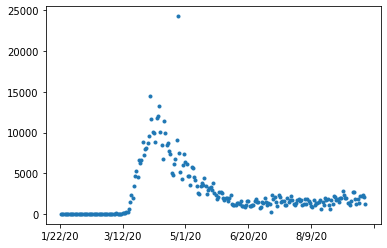

In [14]:
cases_df_norm.T.sum().diff(periods = 1).plot(style='.');

# Calculating First Case

In [20]:
#Calculating first case
first_case_date = [cases_df.T.sum()[cases_df.T.sum() == x].index[0] for x in cases_df.T.sum() if x > 0][0]
first_case_county = [cases_df.loc[first_case_date][cases_df.loc[first_case_date] == x].index[0] for x in cases_df.loc[first_case_date] if x > 0][0]
print("first case in {} in {}".format( first_case_date,first_case_county)) 

first case in 3/2/20 in New York County


**First case in 3/2/20 in New York County in NY state**

In [53]:
cases_df_firstCase = cases_df.loc[first_case_date:,:]
cases_df_firstCase

County Name,Albany County,Allegany County,Bronx County,Broome County,Cattaraugus County,Cayuga County,Chautauqua County,Chemung County,Chenango County,Clinton County,Columbia County,Cortland County,Delaware County,Dutchess County,Erie County,Essex County,Franklin County,Fulton County,Genesee County,Greene County,Hamilton County,Herkimer County,Jefferson County,Kings County,Lewis County,Livingston County,Madison County,Monroe County,Montgomery County,Nassau County,New York County,Niagara County,Oneida County,Onondaga County,Ontario County,Orange County,Orleans County,Oswego County,Otsego County,Putnam County,Queens County,Rensselaer County,Richmond County,Rockland County,St. Lawrence County,Saratoga County,Schenectady County,Schoharie County,Schuyler County,Seneca County,Steuben County,Suffolk County,Sullivan County,Tioga County,Tompkins County,Ulster County,Warren County,Washington County,Wayne County,Westchester County,Wyoming County,Yates County
3/2/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3/3/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3/4/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,0,0
3/5/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0
3/6/20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9/17/20,2969,94,52422,1437,248,194,533,294,245,154,579,141,129,5042,10833,154,63,331,309,319,14,316,159,66586,50,199,480,5839,219,45989,32892,1703,2363,4158,452,11734,322,412,322,1567,71392,892,15666,14698,313,976,1372,83,33,104,339,45915,1565,221,388,2231,352,287,305,37672,130,62
9/18/20,2979,95,52468,1450,249,195,535,305,248,154,580,150,129,5050,10873,157,64,331,309,319,14,318,160,66737,50,201,484,5857,219,46052,32938,1707,2369,4185,454,11760,322,418,324,1569,71474,895,15689,14747,314,985,1374,83,37,105,342,45956,1568,222,390,2235,354,287,306,37718,131,62
9/19/20,3006,96,52526,1459,253,196,536,322,248,154,580,155,130,5053,10917,158,64,332,314,319,15,319,161,66971,50,201,486,5876,223,46154,33011,1714,2373,4201,456,11790,323,424,325,1573,71577,896,15713,14801,315,990,1377,83,37,105,344,46010,1570,222,394,2239,356,287,309,37755,132,62
9/20/20,3016,98,52578,1465,254,199,537,330,248,154,581,159,130,5059,10999,160,65,332,314,319,15,321,163,67136,50,201,487,5894,227,46218,33070,1724,2375,4220,461,11812,323,447,332,1574,71682,899,15730,14823,318,998,1380,83,38,105,350,46061,1571,224,397,2242,360,287,310,37801,132,62


# Linear Vs Non-Linear regression 

In [55]:
county_top5 = cases_df[cases_df.iloc[-1].sort_values(axis=0, ascending=False).index[:5]]
deaths_top5 = deaths_df[cases_df.iloc[-1].sort_values(axis=0, ascending=False).index[:5]]

In [57]:
county_top5

County Name,Queens County,Kings County,Bronx County,Nassau County,Suffolk County
1/22/20,0,0,0,0,0
1/23/20,0,0,0,0,0
1/24/20,0,0,0,0,0
1/25/20,0,0,0,0,0
1/26/20,0,0,0,0,0
...,...,...,...,...,...
9/17/20,71392,66586,52422,45989,45915
9/18/20,71474,66737,52468,46052,45956
9/19/20,71577,66971,52526,46154,46010
9/20/20,71682,67136,52578,46218,46061


In [60]:
#This function returns the rmse for linear and nonlinear and number of day since infection
def linear_vs_NonLinear_RMSE(S1,S2,N):
    linreg = linear_model.LinearRegression()
    polyreg=make_pipeline(PolynomialFeatures(9),linreg)

    X = [x+1 for x in range(len(S1[S1>0]))] 
    y = list(zip(S1[S1>0],S2[S1>0]))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    linreg.fit(np.array(X_train).reshape(-1,1),y_train)
    y_pred = linreg.predict(np.array(X_test).reshape(-1, 1))
    rmse_linear = mean_squared_error(y_test, y_pred, squared=False)
    
    polyreg.fit(np.array(X_train).reshape(-1,1),y_train)
    y_pred = polyreg.predict(np.array(X_test).reshape(-1, 1))
    rmse_nonLinear = mean_squared_error(y_test, y_pred, squared=False)
    print("linear rmse = {:.2f}".format(rmse_linear) , " and non_linear rmse = {:.2f} ".format(rmse_nonLinear), "for ",N)
    return rmse_linear , rmse_nonLinear, N , len(X) 
    


In [61]:
for x in county_top5 :
    linear_vs_NonLinear_RMSE(county_top5[x],county_top5[x],x)

linear rmse = 12564.27  and non_linear rmse = 3530.79  for  Queens County
linear rmse = 10717.35  and non_linear rmse = 2764.11  for  Kings County
linear rmse = 8793.79  and non_linear rmse = 2188.73  for  Bronx County
linear rmse = 8681.53  and non_linear rmse = 2514.67  for  Nassau County
linear rmse = 7957.17  and non_linear rmse = 2202.22  for  Suffolk County


In [62]:
for x in county_top5 :
    linear_vs_NonLinear_RMSE(deaths_top5[x],county_top5[x],x)

linear rmse = 6087.18  and non_linear rmse = 3235.11  for  Queens County
linear rmse = 6986.91  and non_linear rmse = 2599.29  for  Kings County
linear rmse = 5907.13  and non_linear rmse = 2203.61  for  Bronx County
linear rmse = 5341.75  and non_linear rmse = 2441.44  for  Nassau County
linear rmse = 5277.75  and non_linear rmse = 2163.71  for  Suffolk County


In [26]:
def pipline(s,N):
    first_day= s[s>0].index[0]
    S= s.loc[first_day:]
    X = np.array([x for x in range(len(S))]).reshape(-1,1)
    y = np.array([y for y in S]).reshape(-1,1)
    reg = linear_model.LinearRegression()
    degree = 6
    regpol = polyreg=make_pipeline(PolynomialFeatures(degree),reg)
    reg.fit(X,y)
    y_pred_lin = reg.predict(X)
    regpol.fit(X,y)
    y_pred_pol = regpol.predict(X)
    
    rmse_linear = mean_squared_error(y, y_pred_lin, squared=False)
    rmse_nonLinear = mean_squared_error(y, y_pred_pol, squared=False)
    
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    sns.scatterplot(ax=ax,data=S)
    df = pd.DataFrame(list(zip(y_pred_lin,y_pred_pol)),columns=['Linear','Non_linear'],index=S.index)
    df['Linear'] = [x[0] for x in df['Linear']]
    df['Non_linear'] = [x[0] for x in df['Non_linear']]
    sns.lineplot(ax=ax,data=df,palette=['r','g'],alpha=.8)
    ax.set_title("New your {} Linear model rmse {:.2f} Vs. Non_linear model rmse {:.2f} with degree of {}".format(N,rmse_linear,rmse_nonLinear,degree))
    ax.set_ylim(0)
    plt.xticks(ticks=[df.index[x] for x in range(1,len(df.index),7) ],rotation=45)
    

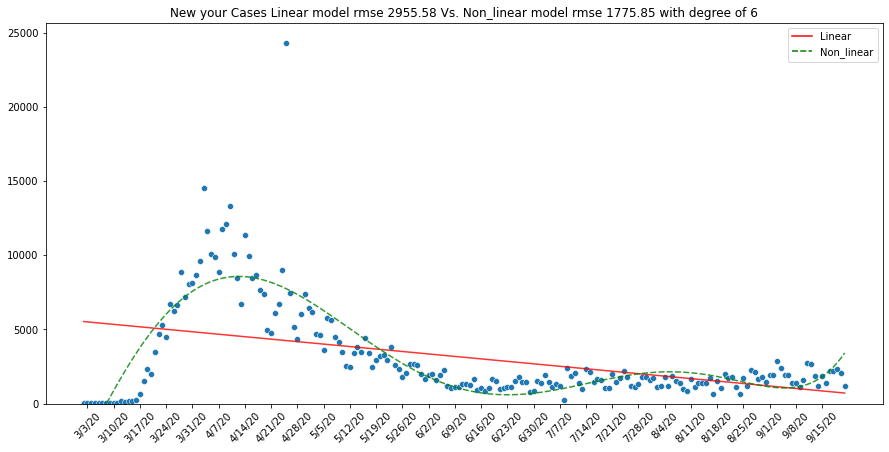

In [27]:
pipline(cases_df_norm.T.sum().diff(periods = 1),'Cases')


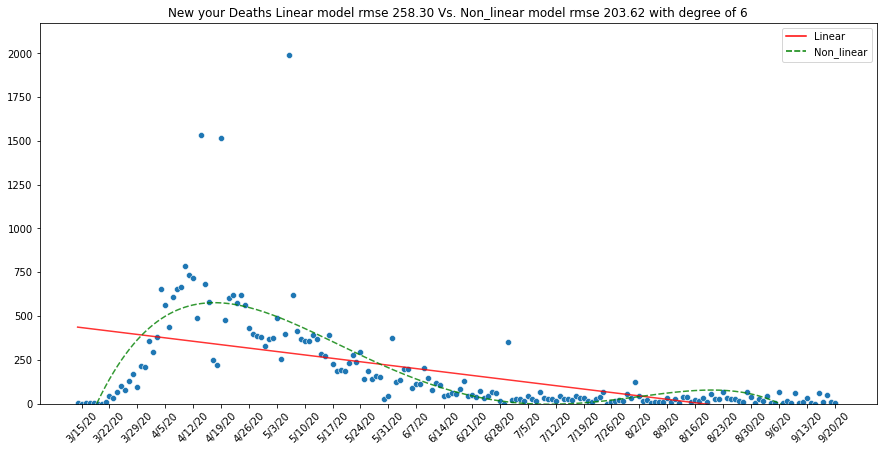

In [28]:
pipline(deaths_df_norm.T.sum().diff(periods = 1),'Deaths')

#Trend exploration & Top 5 Counties at risk

In [70]:

def trend_explor(series_1,series_2,name):
  #locate first case
    first_case_date = [series_1[series_1==x].index[0] for x in series_1 if x>0][0]
    series_1 = series_1.loc[first_case_date:] 
  #calculate dailycase 
    series_1_zipped = [x[1]-x[0] for x in zip(series_1[:-1],series_1[1:])]
    series_2 = series_2.loc[first_case_date:]
    series_2_zipped = [x[1]-x[0] for x in zip(series_2[:-1],series_2[1:])]
    
    base = [series_1[series_1==x].index[0] for x in series_1 if x>0][-1]
    date_list = [datetime.datetime.strptime(base,'%m/%d/%y').date() - datetime.timedelta(days=x) for x in range(len(series_1_zipped))]
    
    fig, ax = plt.subplots(1,2,figsize=(15,3),sharex=True,sharey=True)
    fig.suptitle(" The first day of infection is {} in {}".format(first_case_date,name))
    ax[0].set_title( "cases in {}".format(name),y=1.0, pad=-14)
    ax[0].set_ylim(-100,1200)
    first_case_date = '4/2/20'
    leftlim = first_case_date
    rightlim = '9/20/20'
    ax[0].set_xlim(left=datetime.datetime.strptime(str(leftlim),'%m/%d/%y').date(), right=datetime.datetime.strptime(rightlim,'%m/%d/%y').date())

    ax[1].set_title( " deaths in {}".format(name),y=1.0, pad=-14)
    return sns.scatterplot(ax=ax[0],y = series_1_zipped , x=date_list,color='b'), sns.scatterplot(ax=ax[1],y = series_2_zipped , x=date_list,color='r')

    

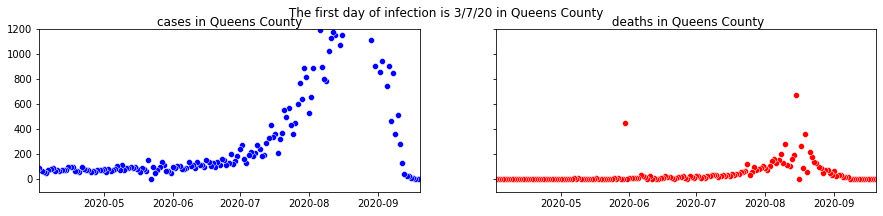

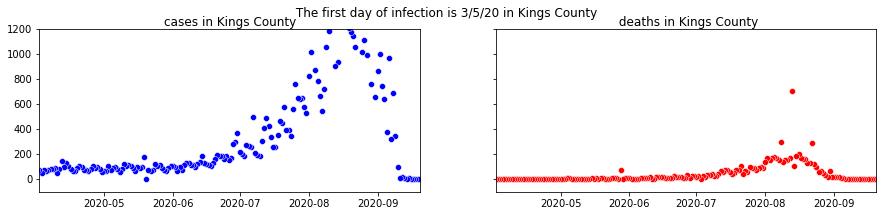

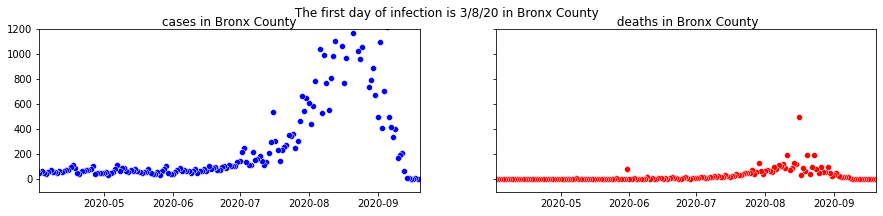

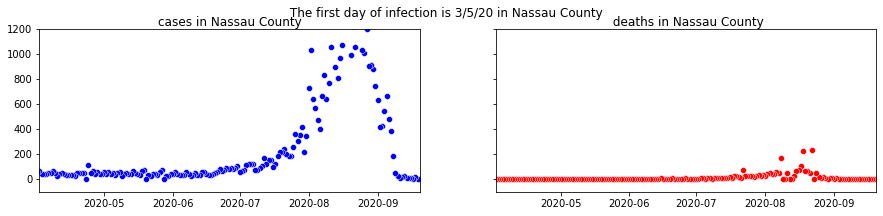

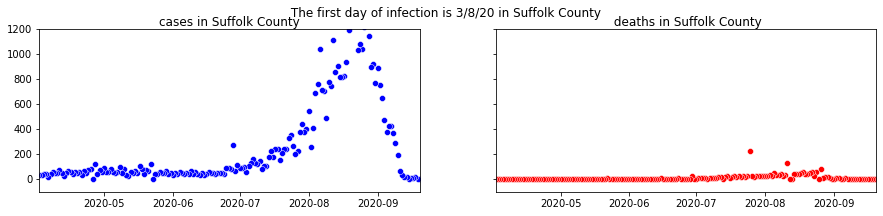

In [71]:
for x in county_top5 :
    trend_explor(county_top5[x],deaths_top5[x],x)


# Utilize decision tree, random forest, and ARIMA based models to compare and contrast the performance of each.

 (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ )  
 
 X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.

In [ ]:
!pip install pmdarima 

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from pmdarima import auto_arima 

def decisionTree_randomForest_ARIMA(S,n):
    S = S[S>0]
    S = S.to_frame().reset_index()    
    S['index'] = pd.to_datetime(S['index'])
    S['week'] = S['index'].dt.week
    S[n][1:] = [x-y for x,y in list(zip(S[n][1:],S[n][:-1]))]
    S.groupby("week").agg(sum)
    X = S[n][:-1]
    y = S[n][1:]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False,stratify = None)
    dt_regr = DecisionTreeRegressor(criterion = 'mse', max_depth=5)
    dt_regr.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))
    dt_pred = dt_regr.predict(X_test.values.reshape(-1,1))
    dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)

    RF_regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=5,random_state=42)
    RF_regr.fit(X_train.values.reshape(-1,1),y_train.values.reshape(-1,1))
    RF_regr_pred = RF_regr.predict(X_test.values.reshape(-1,1))
    RF_rmse = mean_squared_error(y_test, RF_regr_pred, squared=False)
    
    ARIMA = auto_arima(X_train, start_p = 1, start_q = 1, 
                              max_p = 3, max_q = 3, m = 12, 
                              start_P = 0, seasonal = True, 
                              d = None, D = 1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)
    
    ARIMA_pred = ARIMA.predict(n_periods=len(X_test))
    ARIMA_rmse = mean_squared_error(X_test, ARIMA_pred, squared=False)
    print("ARIMA rmse = {:.2f} ".format(ARIMA_rmse) , "Decision Tree rmse = {:.2f} ".format(dt_rmse), " Random Froest rmse {:.2f} ".format(RF_rmse),"for",n)
    
    fig,ax = plt.subplots(1,1,figsize=(15,7))
    sns.scatterplot(x=[x for x in range(len(X))],y=y)
    sns.lineplot(x=[x for x in range(len(X))],y=ARIMA.predict(n_periods=len(X)),label="ARIMA Model",color ='r')
    sns.lineplot(x=[x for x in range(len(X))],y=dt_regr.predict(X.values.reshape(-1,1)),label="Decision Tree Model",color ='c')
    sns.lineplot(x=[x for x in range(len(X))],y=RF_regr.predict(X.values.reshape(-1,1)),label="Random Forest Model",color ='g')
    
    return ARIMA_rmse, dt_rmse, RF_rmse
    
        
#for x in county_top5:
    #decisionTree_randomForest_ARIMA(county_top5[x],x)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2005.817, Time=1.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2110.347, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2048.184, Time=0.33 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2005.145, Time=1.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2057.843, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=2.07 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2038.448, Time=0.34 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=7.83 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.33 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=2005.831, Time=1.13 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=2011.769, Time=1.15 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2007.090, Time=1.49 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=2005.897, Time=1.42 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]  

(61.682236961621896, 19.300310507271206, 17.80203454527151)

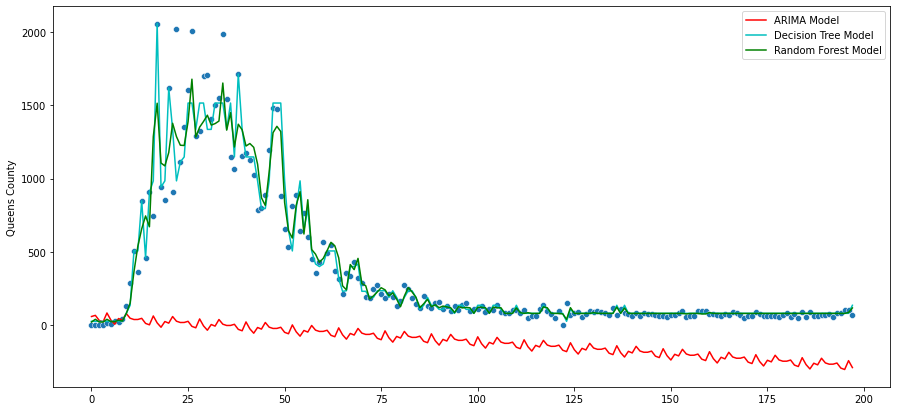

In [75]:
#Queens County
decisionTree_randomForest_ARIMA(county_top5['Queens County'],'Queens County')

**ARIMA rmse = 61.68 Decision Tree rmse = 19.30 Random Froest rmse 17.80  for Queens County**

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2049.489, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1989.608, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=2039.442, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1969.996, Time=0.73 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.25 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1977.224, Time=0.57 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1952.951, Time=1.16 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1973.643, Time=0.39 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=2.97 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.08 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1954.607, Time=0.87 sec
 ARIMA(2,1,1)(2,1,0)[12]             : AIC=1953.0

(19.988952691811264, 15.417058293578657, 16.203901187078632)

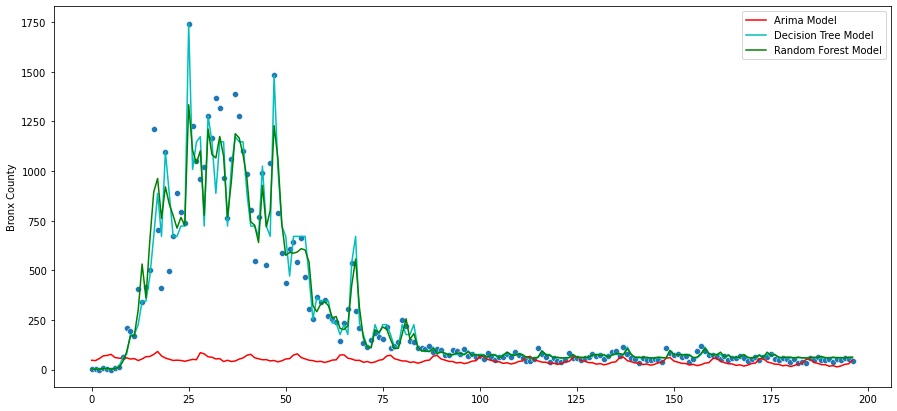

In [71]:
#Bronx County
decisionTree_randomForest_ARIMA(county_top5['Bronx County'],'Bronx County')

**ARIMA rmse = 19.99  Decision Tree rmse = 15.42   Random Froest rmse 16.20  for Bronx County**

Random Froest has the smaller RMSE than ARIMA and Decision tree thus Random Froest is a better fit for this dataset

#Utilize the hospital data to calculate the point of no return for top 5 counties of NY

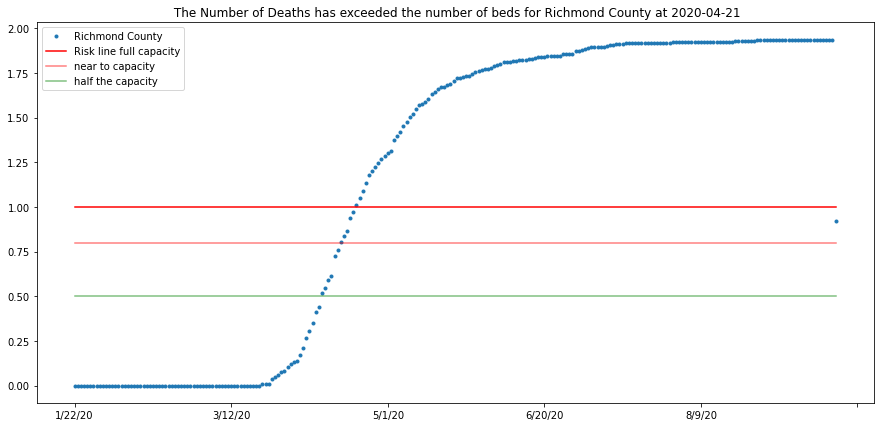

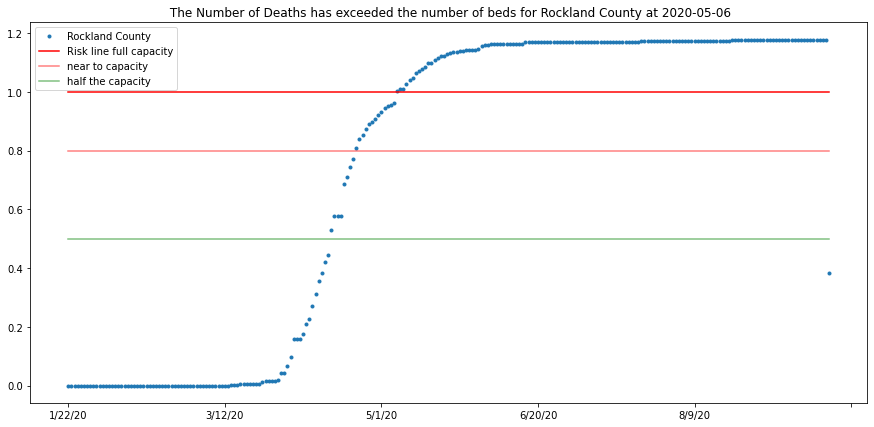

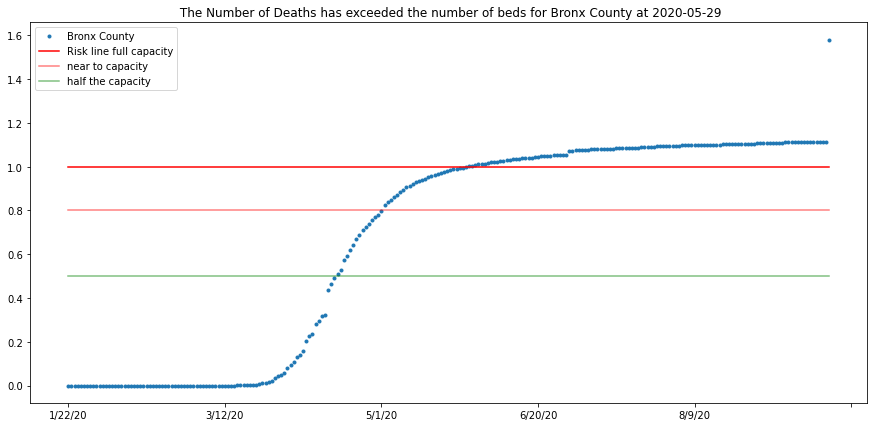

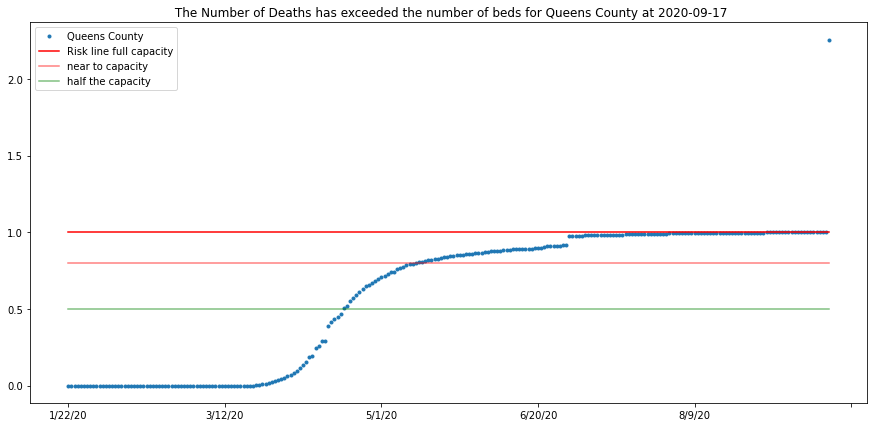

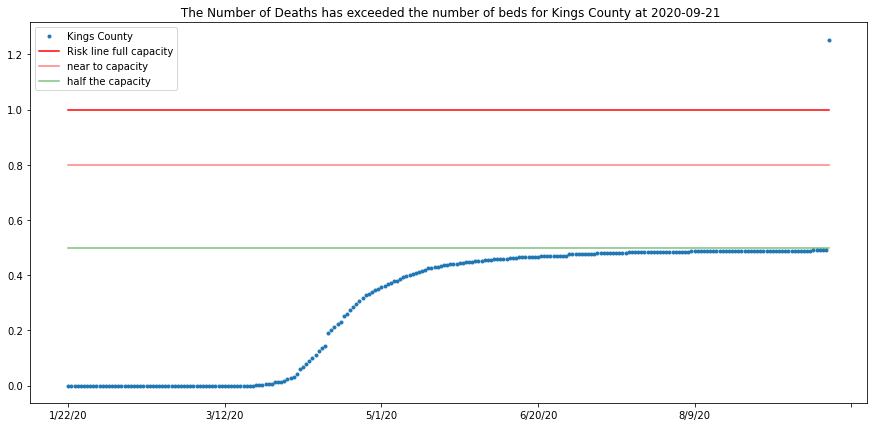

In [36]:
combined_df_indexed = combined_df[combined_df['NUM_LICENSED_BEDS']>1000].set_index('County Name')
Num_of_beds = combined_df_indexed['NUM_LICENSED_BEDS']
Counties_at_risk={}
for x in deaths_df_norm :
  if x in combined_df_indexed.index:
    y = deaths_df_norm[x]/Num_of_beds.loc[x]
    try:
        day_of_risk = y[y>1].index[0]
        day_of_risk = datetime.datetime.strptime(day_of_risk,'%m/%d/%y').date()
    
        Counties_at_risk[x] = day_of_risk
    except:
        pass
Counties_at_risk = pd.DataFrame(Counties_at_risk.values(),Counties_at_risk.keys()).sort_values(0)
counties_at_risk_top5 = Counties_at_risk[:5]
for x in counties_at_risk_top5.index:
        y =  deaths_df_norm[x]/Num_of_beds.loc[x]
        day_of_risk = y[y>1].index[0]
        day_of_risk = datetime.datetime.strptime(day_of_risk,'%m/%d/%y').date()
        fig, ax = plt.subplots(1,1,figsize=(15,7))
        y.plot(ax=ax,style='.')
        sns.lineplot(x=y.index,y=[1]*len(y),color='r',label='Risk line full capacity')
        sns.lineplot(x=y.index,y=[.8]*len(y),color='r',alpha=.5,label ='near to capacity' )
        sns.lineplot(x=y.index,y=[.5]*len(y),color='g',alpha=.5,label ='half the capacity' )
        ax.set_title(" The Number of Deaths has exceeded the number of beds for {} at {}".format(x,counties_at_risk_top5.loc[x][0]))


 
# Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [81]:
combined_df["occupancy / utilization"] = combined_df[[x for x in combined_df if x.startswith('deaths') is True][-1]]/ combined_df['NUM_STAFFED_BEDS']
combined_df.sort_values("occupancy / utilization",ascending=False,inplace=True)

In [82]:
county_top5_h = cases_df[combined_df['County Name'][:5]]
deaths_top_h = deaths_df[combined_df['County Name'][:5]]
county_top5_h

County Name,Queens County,Orleans County,Kings County,Bronx County,Richmond County
1/22/20,0,0,0,0,0
1/23/20,0,0,0,0,0
1/24/20,0,0,0,0,0
1/25/20,0,0,0,0,0
1/26/20,0,0,0,0,0
...,...,...,...,...,...
9/17/20,71392,322,66586,52422,15666
9/18/20,71474,322,66737,52468,15689
9/19/20,71577,323,66971,52526,15713
9/20/20,71682,323,67136,52578,15730


In [84]:
deaths_top_h

County Name,Queens County,Orleans County,Kings County,Bronx County,Richmond County
1/22/20,0,0,0,0,0
1/23/20,0,0,0,0,0
1/24/20,0,0,0,0,0
1/25/20,0,0,0,0,0
1/26/20,0,0,0,0,0
...,...,...,...,...,...
9/17/20,7238,55,7312,4934,1084
9/18/20,7239,55,7314,4934,1085
9/19/20,7243,55,7315,4939,1085
9/20/20,7243,55,7318,4941,1085


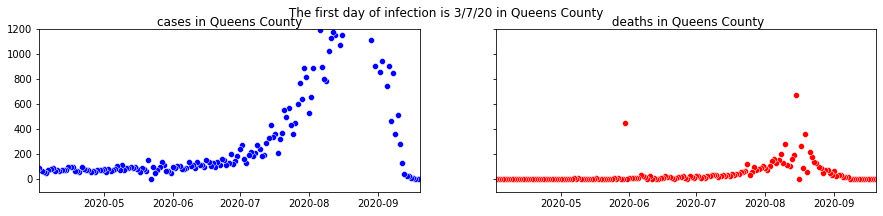

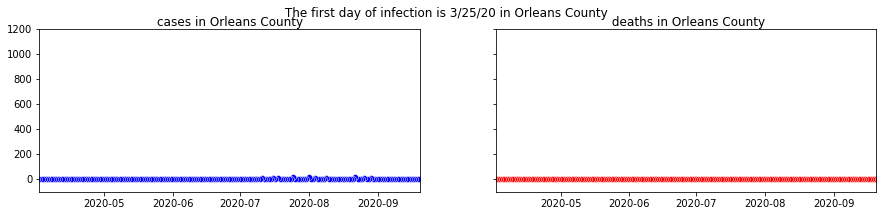

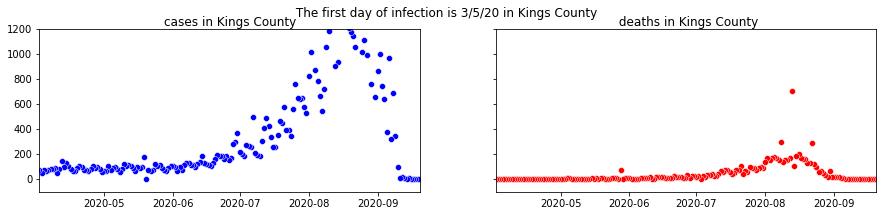

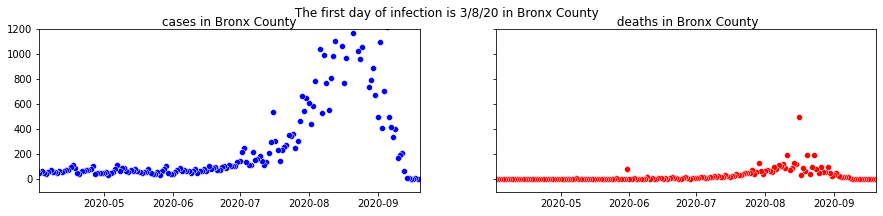

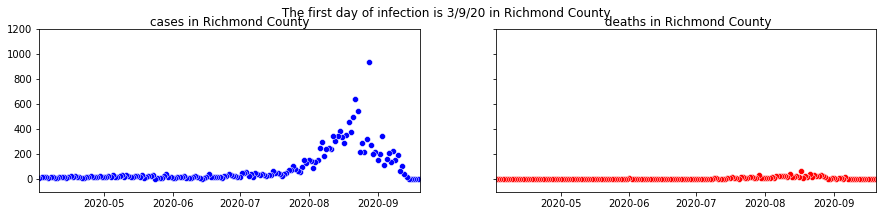

In [85]:
for x in county_top5_h:
    trend_explor(county_top5_h[x],deaths_top_h[x],x)

##     Use 5 different variables from the enrichment data to predict the spread rate (cases and deaths) of COVID-19 in a county. Compare Random Forest and Decision Trees (RMSE error). 

- For example, percentage of population in certain age-group, socio-economic status, public transportation, work from home, etc. 
- Show the relative importance of variables and explain why. Here you are using the variables for prediction of cases (multi-variable) regression. Stage II was just correlation.



In [141]:
Features= [ x for x in combined_df if x.startswith("confirmed") is False and x.startswith("deaths") is False ]
Cases = [x for x in combined_df if x.startswith("confirmed") is True]
Deaths = [x for x in combined_df if x.startswith("deaths") is True]

def MultiVarients_df(S1,S2,N):
    df={}
    
    first_case_date = [S1[S1==x].index[0] for x in S1 if x>0][0]
    S1 = S1.loc[first_case_date:]
    S1 = [x[1]-x[0] for x in zip(S1[:-1],S1[1:])]
    S2 = S2.loc[first_case_date:]
    S2 = [x[1]-x[0] for x in zip(S2[:-1],S2[1:])]
    df['y'] = list(zip(S1,S2))
    for F in Features:
        
        if F not in 'County Name':
            df[F] = [x[0]/(x[1]+1) for x in zip(S2,[combined_df[combined_df['County Name']== x][F].values[0]]*len(S1))]
    df = pd.DataFrame(df)
    rf = RandomForestRegressor()
    Y = [x[0] for x in df['y']]
    X = df.drop('y',axis=1).values
    rf.fit(X, Y)
    print("Features sorted by their score:")
    print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), df.columns), 
             reverse=True))
    return pd.DataFrame(df)

In [147]:
dts=[]
rfs = []
dt_errors =[]
rf_errors = []
names = []
for x in  county_top5:   
    df = MultiVarients_df(county_top5[x],deaths_top5[x],x)
   
  
    columns_to_remove =[ 'y',	'X', 	'Y', 	'OBJECTID', 	'HQ_ZIP_CODE', 	'STATE_FIPS', 	'CNTY_FIPS'] 
    y = [x[0] for x in df['y']]
    X= df.drop(columns_to_remove,axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle=False,stratify = None)

    print("Start Decision Tree for {}".format(x))
    dt_regr = DecisionTreeRegressor(criterion = 'mse', max_depth=5)
    dt_regr.fit(X_train.values,y_train)
    dt_pred = dt_regr.predict(X_test.values)
    dt_rmse = mean_squared_error(y_test, dt_pred, squared=False)
    print("end of Decision Tree for {} rmse = {:.2f}".format(x,dt_rmse))


    print("Start Random forest  for {}".format(x))
    RF_regr = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=5)
    RF_regr.fit(X_train.values,y_train)
    RF_regr_pred = RF_regr.predict(X_test.values)
    RF_rmse = mean_squared_error(y_test, RF_regr_pred, squared=False)
    print("end of Random Tree for {} rmse = {:.2f}".format(x,RF_rmse))

    dts.append(dt_regr)
    rfs.append(RF_regr)
    dt_errors.append(dt_rmse)
    rf_errors.append(RF_rmse)
    names.append(x)

   

Features sorted by their score:
[(0.1068, 'Potential_Increase_In_Bed_Capac'), (0.0982, 'y'), (0.0816, 'NUM_ICU_BEDS'), (0.0799, 'Y'), (0.0757, 'PEDI_ICU_BEDS'), (0.0738, 'CNTY_FIPS'), (0.0681, 'OBJECTID'), (0.0589, 'NUM_LICENSED_BEDS'), (0.0571, 'population'), (0.057, 'STATE_FIPS'), (0.0546, 'X'), (0.0495, 'NUM_STAFFED_BEDS'), (0.048, 'ADULT_ICU_BEDS'), (0.0474, 'BED_UTILIZATION'), (0.0434, 'HQ_ZIP_CODE')]
Start Decision Tree for Queens County
end of Decision Tree for Queens County rmse = 80.35
Start Random forest  for Queens County
end of Random Tree for Queens County rmse = 78.89
Features sorted by their score:
[(0.1004, 'y'), (0.0941, 'OBJECTID'), (0.0817, 'Potential_Increase_In_Bed_Capac'), (0.0805, 'ADULT_ICU_BEDS'), (0.0767, 'CNTY_FIPS'), (0.0757, 'NUM_STAFFED_BEDS'), (0.0743, 'population'), (0.0652, 'STATE_FIPS'), (0.0569, 'BED_UTILIZATION'), (0.0562, 'NUM_LICENSED_BEDS'), (0.0523, 'PEDI_ICU_BEDS'), (0.0516, 'NUM_ICU_BEDS'), (0.0482, 'X'), (0.0472, 'HQ_ZIP_CODE'), (0.0391, 'Y')]

Features sorted by their score:
[(0.1084, 'NUM_LICENSED_BEDS'), (0.0903, 'y'), (0.0859, 'NUM_STAFFED_BEDS'), (0.0779, 'NUM_ICU_BEDS'), (0.0748, 'OBJECTID'), (0.0737, 'HQ_ZIP_CODE'), (0.0684, 'PEDI_ICU_BEDS'), (0.0644, 'X'), (0.0589, 'Y'), (0.0584, 'population'), (0.0584, 'STATE_FIPS'), (0.0559, 'Potential_Increase_In_Bed_Capac'), (0.0485, 'CNTY_FIPS'), (0.0406, 'BED_UTILIZATION'), (0.0356, 'ADULT_ICU_BEDS')]
Start Decision Tree for Richmond County
Features sorted by their score:
[(0.106, 'NUM_STAFFED_BEDS'), (0.101, 'HQ_ZIP_CODE'), (0.0832, 'CNTY_FIPS'), (0.0742, 'X'), (0.0726, 'population'), (0.0693, 'BED_UTILIZATION'), (0.0673, 'ADULT_ICU_BEDS'), (0.0666, 'STATE_FIPS'), (0.064, 'NUM_LICENSED_BEDS'), (0.0624, 'NUM_ICU_BEDS'), (0.0547, 'y'), (0.0541, 'Potential_Increase_In_Bed_Capac'), (0.0501, 'PEDI_ICU_BEDS'), (0.0431, 'OBJECTID'), (0.0315, 'Y')]
Start Decision Tree for Richmond County
Features sorted by their score:
[(0.0981, 'CNTY_FIPS'), (0.0888, 'BED_UTILIZATION'), (0.0825, 'PEDI

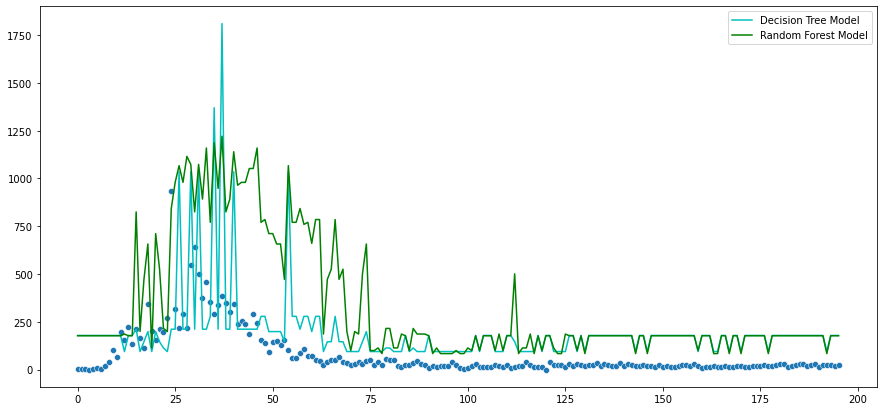

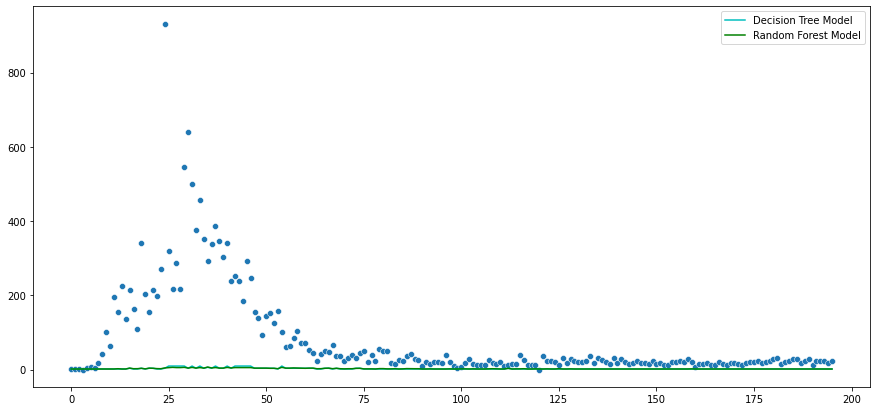

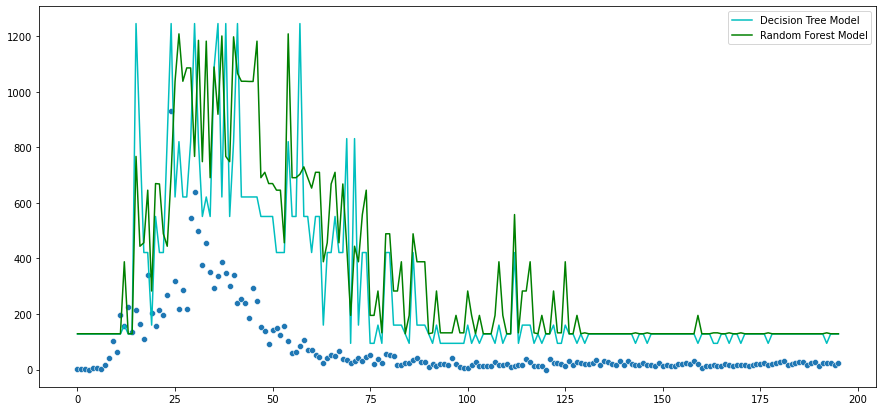

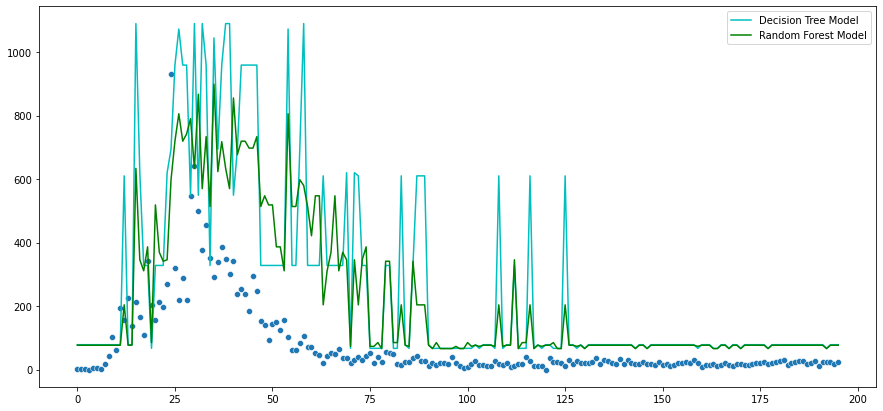

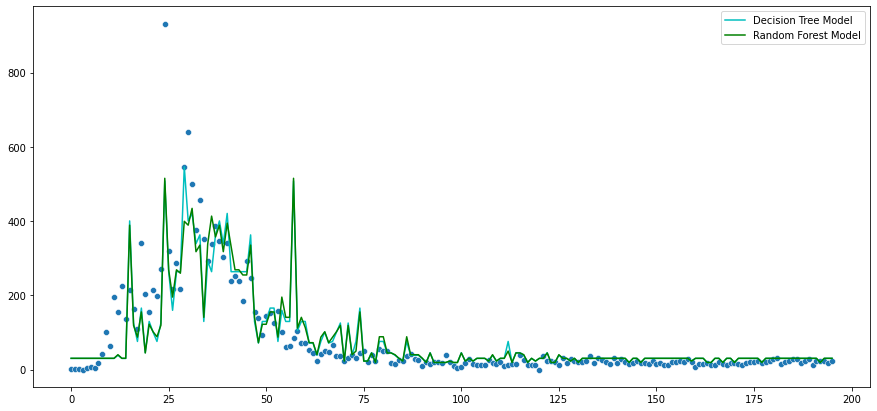

In [150]:
for idx,item in enumerate(county_top5):   
    df = MultiVarients_df(county_top5[x],deaths_top5[x],x)
    print("Start Decision Tree for {}".format(x))
    columns_to_remove =[ 'y',	'X', 	'Y', 	'OBJECTID', 	'HQ_ZIP_CODE', 	'STATE_FIPS', 	'CNTY_FIPS']    
    y = [x[0] for x in df['y']]
    X= df.drop(columns_to_remove,axis=1)
    fig, ax = plt.subplots(1,1,figsize=(15,7))
    sns.scatterplot(x=[x for x in range(len(X))],y=y)

    sns.lineplot(x=[x for x in range(len(X))],y=dts[idx].predict(X.values),label="Decision Tree Model",color ='c')

    sns.lineplot(x=[x for x in range(len(X))],y=rfs[idx].predict(X.values),label="Random Forest Model",color ='g')